## Notebook to solve 1D elliptic, self adjoint eigenvalue problem

Here we solve a (formally) self adjoint, regular elliptic problem in 1D, the problem is of the form:

$$ -\frac{d}{dx}(p(x)\frac{d}{dx}u) + q(x) u(x) = \lambda r(x) u(x)$$

with $p(x) > 0$. We solve it in an interval $[0,L]$ and use boundary conditions $\{u_0=0, u_1=0\}$ at the left-right boundaries. 

In [22]:
import Pkg; Pkg.activate("../Tarea_5/gridap_makie")
using Gridap
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
mkdir("images")
using GridapGmsh
using Gmsh
import Pkg; Pkg.add("LinearAlgebra"); Pkg.add("SparseArrays"); Pkg.add("SuiteSparse");  Pkg.add("Arpack")
using LinearAlgebra
using SparseArrays
using SuiteSparse
using Arpack


  Activating project at `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie`
   Resolving package versions...
  No Changes to `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie/Project.toml`
  No Changes to `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie/Project.toml`
  No Changes to `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie/Project.toml`
  No Changes to `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie/Project.toml`
  No Changes to `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie/Manifest.toml`


In [23]:
include("models/mesh_generator.jl")


make_model (generic function with 1 method)

We define several instances:

#### Test 1 is just the second derivatives (p=1, q=0, r=1)
The solutions are $u_n = sin(n*x)$ in the interval $[0,\pi]$, and the eigenvalues are $\lambda_n = n^2$.

#### Test 2 has (p=x, q=0, r=1/x)
The solutions are: $(\lambda = (\frac{n\pi}{\ln L})^2\;\;\;\; n>0, u_n = \sin(\frac{n\pi}{\ln L}\ln x)$, in the interval $[1,L]$.

#### Test 3 the harmonic oscillator (p=1, q=x^2, r=1)
The solutions are: $(\lambda = 1 + 2n, \;\;\; n\geq 0, u_n = e^{-x^2/2}H_n)$, where $H_n$ are the Hermite polynomials.


In [24]:
test_1 = false 
test_2 = false
test_3 = false
#test_1 = true
#test_2 = true 
#test_3 = true 


false

Define an equi-spaced grid with N nodes of length L

In [25]:
# Create mesh with N point

if test_1 
    
    grid_type = "1D"
    h = 1/200
    par = (0,π, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0

elseif test_2
    
    grid_type = "1D"
    h = 1/200
    L = 2
    par = (1,L, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
elseif test_3
    
    grid_type = "1D"
    h = 1/20000
    par = (-10,10, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
else
    
    grid_type = "1D"
    h = 1/1000
    par = (0.,20., h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
end

model = make_model(grid_type, par)


Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.00983145s, CPU 0.008173s)
Info    : 20001 nodes 20002 elements
Info    : Writing 'models/1D.msh'...
Info    : Done writing 'models/1D.msh'
Info    : Reading 'models/1D.msh'...
Info    : 3 entities
Info    : 20001 nodes
Info    : 20002 elements
Info    : Done reading 'models/1D.msh'


UnstructuredDiscreteModel()

In [26]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)


Measure()

In [27]:
fig, ax = plot(Ω)
#scatter!(Ω, marker=:star8, markersize=4, color=:blue)
wireframe!(Ω, color=:black, linewidth=2)
fig


In [28]:
#Γ = BoundaryTriangulation(model,tags=boundary_tags)
#dΓ = Measure(Γ,degree)
#fig, ax = plot(Γ, linewidth=8)
#ax.aspect = AxisAspect(1)
#wireframe!(Γ, color=:black, linewidth=1)
#fig

In [29]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)

V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
U = TrialFESpace(V,dirichlet_values)


TrialFESpace()

Since we shall be solving it with finite elements we first define the fuction space for these elements:

We define the two free fuctions, $g$ and $pot$. To test the code we have three test cases, for which the functions are simple and we know the solution explicitly. The fourth case is just some potential???

In [30]:
#cambiamos el signo de p con respecto a la definición anterior
if test_1
    p(x) = 1
    q(x) = 0
    r(x) = 1
elseif test_2
    p(x) = x[1]
    q(x) = 0
    r(x) = 1/x[1]
elseif test_3
    p(x) = 1
    q(x) = x[1]*x[1]
    r(x) = 1
else
    p(x) = (1 + x[1] + 0.5*x[1]*x[1])/(10 + 0.5*x[1]*x[1]) # don't remember this potential...
    q(x) = -10*x[1]/(1 + 5*x[1]*x[1])
    r(x) = 1
end


r (generic function with 1 method)

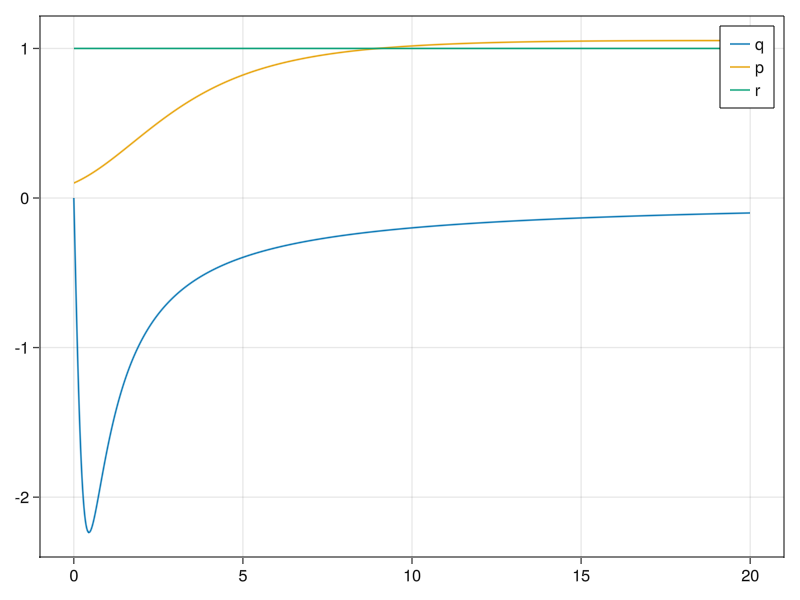

In [31]:
x = range(par[1], par[2], length=1000)
yq = q.(x)
yp = p.(x)
yr = r.(x)
lines(x, yq, label= "q")
lines!(x, yp, label= "p")
lines!(x, yr, label= "r")
axislegend()
current_figure()


Now we define the variational problem

In [32]:
a(u,v) = ∫(p*∇(v)⋅∇(u) + q*v*u)*dΩ # deben verificar la integración por partes
m(u,v) = ∫(r*u*v)dΩ


m (generic function with 1 method)

Here we introduce the solver and its parámeters, and the solve the system.

In [33]:
include("eigen.jl")


solve (generic function with 1 method)

In [34]:
nev = 12 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev=nev, tol=10^(-6), maxiter=100, explicittransform=:none, sigma=-1.0)
#prob = EigenProblem(a, m, U, V; nev=nev, which=:LM, explicittransform=:auto, tol=10^(-6), maxiter=100, sigma=0)
ξ, uₕs = solve(prob);


We now illustrate how to manipulate the solutions (eigenfunctions and eigenvalues)

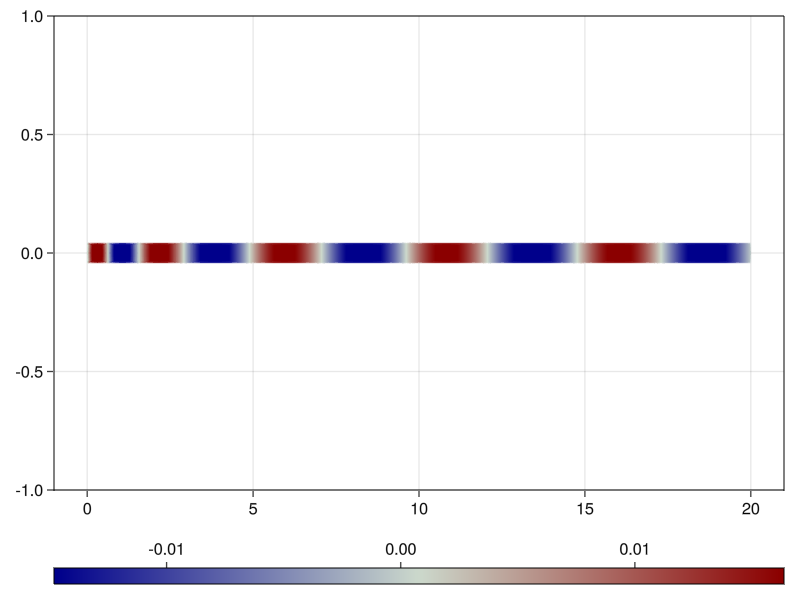

In [35]:
uₕ = uₕs[10]
fig, ax, plt = plot(Ω, real(uₕ), linewidth=20)
#ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

Mostramos las autofunciones numéricas

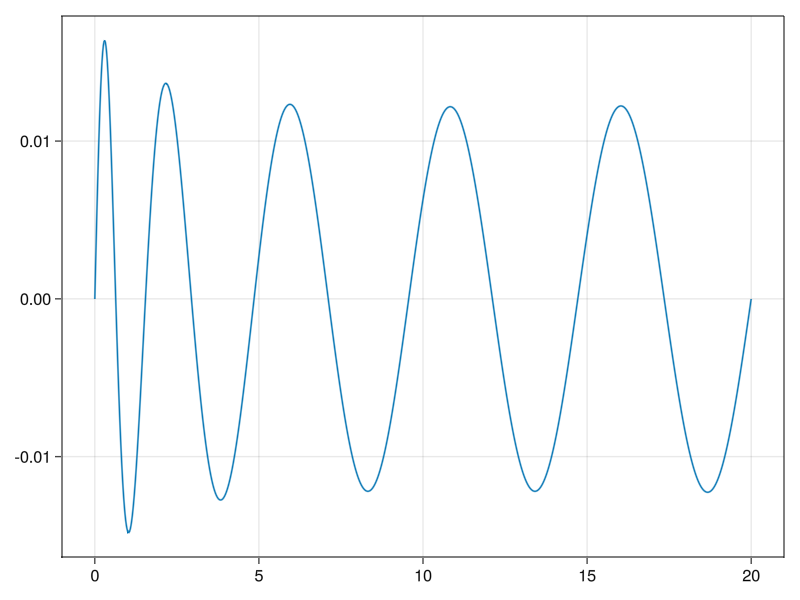

In [36]:
x = range(par[1], par[2], length=1000)
lines(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "u")

#=
    usamos evaluate() para interpolar la autofunción uₕ a los puntos de la grilla x
=#

In [37]:
fig = Figure()

ax = Axis(fig[1, 1], xlabel = "eigenvalue number", ylabel = "value",
    title = "Eigenvalues", yscale = log10, xscale = log10)

scatter!(sort(real(ξ[1:nev])), label = "computed")

if test_1
    scatter!(ax,[n^2 for n ∈ 1:nev], marker=:star8, label = "true")
elseif test_2
    scatter!([(n*π/log(L))^2 for n ∈ 1:nev], marker=:star8, label = "true")
elseif test_3
    scatter!([1 + 2*(n-1) for n ∈ 1:nev], marker=:star8, label = "true")
end
axislegend()
current_figure()
fig

In [38]:
ξ

12-element Vector{ComplexF64}:
  -1.3852324587194522 + 1.6091014142237015e-14im
  -0.5372895514092335 + 6.088561574847766e-14im
 -0.21718933615871627 - 1.5592533829720123e-12im
 -0.08921041034240218 + 1.179426042251887e-12im
   0.0414351772861663 - 6.258637670830007e-13im
  0.22155871111134728 - 1.3877051144122343e-12im
   0.4469976271514746 + 1.8128383168336595e-13im
   0.7147689402998891 - 1.1721797626699927e-13im
   1.0231860273839803 - 1.2739973146192683e-13im
   1.3711976375264592 + 2.103507100697088e-12im
   1.7581089074705036 + 7.800820126597652e-14im
    2.183444405320076 - 4.473756499652714e-12im

And here we can save them into a file to see it with visit, for instance. 

In [43]:
if test_1 || test_2 || test_3
    n=4 # for test_3 use n=4

    uₕ = uₕs[n]
    # normalize the eigenvalue
    u2 = sum(∫(uₕ*uₕ)*dΩ)
    uₕ = uₕ/sqrt(u2)

    if test_1
        u_n(x) = -sin(n*x)/sqrt(π/2)
    elseif test_2
        freq=n*π/log(L)
        u_n(x) = sqrt((4*freq^2+1)/(2(L-1)*freq^2))*sin(freq*log(x))
    elseif test_3
        u_n(x) = -exp(-x^2/2)*(8x^3-12x)/sqrt(85.0778) 
    end

    x = range(par[1], par[2], length=1000)
    scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "computed")
    lines!(x, u_n.(x), label= "exact")
    scatter!(x, 100000*(evaluate(real(uₕ),Gridap.Point.(x))-u_n.(x)), label= "error x 10^5")
    axislegend()
    current_figure()   
end

In [40]:
typeof(nothing)


Nothing

In [41]:
?eigs()

```
eigs(A; nev=6, ncv=max(20,2*nev+1), which=:LM, tol=0.0, maxiter=300, sigma=nothing, ritzvec=true, explicittransform=:auto, v0=zeros((0,)), check=0) -> (d,[v,],nconv,niter,nmult,resid)
```

Computes eigenvalues `d` of `A` using implicitly restarted Lanczos or Arnoldi iterations for real symmetric or general nonsymmetric matrices respectively. See [the manual](@ref man-eigs) for more information.

`eigs` returns the `nev` requested eigenvalues in `d`, the corresponding Ritz vectors `v` (only if `ritzvec=true`), the number of converged eigenvalues `nconv`, the number of iterations `niter` and the number of matrix vector multiplications `nmult`, as well as the final residual vector `resid`. The parameter `explicittransform` takes the values `:auto`, `:none` or `:shiftinvert`, specifying if shift and invert should be explicitly invoked in julia code.

When `check = 0`, an error is thrown if maximum number of iterations taken (`info = 1`). This usually means all possible eigenvalues has been found according to ARPACK manual. When `check = 1`, return currently converged eigenvalues when `info = 1`. And a `@warn` will given. When `check = 2`, return currently converged eigenvalues when `info = 1`.

# Examples

```jldoctest
julia> using LinearAlgebra, Arpack

julia> A = Diagonal(1:4);

julia> λ, ϕ = eigs(A, nev = 2);

julia> λ
2-element Array{Float64,1}:
 3.9999999999999996
 3.000000000000001
```

---

```
eigs(A, B; nev=6, ncv=max(20,2*nev+1), which=:LM, tol=0.0, maxiter=300, sigma=nothing, ritzvec=true, v0=zeros((0,)), check=0) -> (d,[v,],nconv,niter,nmult,resid)
```

Computes generalized eigenvalues `d` of `A` and `B` using implicitly restarted Lanczos or Arnoldi iterations for real symmetric or general nonsymmetric matrices respectively. See [the manual](@ref man-eigsgen) for more information.

When `check = 0`, an error is thrown if maximum number of iterations taken (`info = 1`). This usually means all possible eigenvalues has been found according to ARPACK manual. When `check = 1`, return currently converged eigenvalues when `info = 1`. And a `@warn` will given. When `check = 2`, return currently converged eigenvalues when `info = 1`.
